### AAI-530 Final Project: Delivery Drone Flight Predictions
<br>Group 6: Ahmed Salem, Matt Thompson, Darin Verduzco
<br>GitHub: https://github.com/caliskate/delivery-drone-flight-predictions
<br>Dataset source: https://doi.org/10.1184/R1/12683453.v1

### Dataset descriptions:
(196 flights total, 18 unique flight dates, 11.5 average number of flights per day)

| **Variable**            | **Description**                                                                                                                                 |
|-------------------------|-------------------------------------------------------------------------------------------------------------------------------------------------|
| **flight**              | An integer that represents the code of the flight performed. A flight is defined as the dataset recorded from take-off to landing on a predefined route. |
| **time**                | Seconds elapsed after flight start time.                                                                                                        |
| **wind_speed**          | Airspeed provided by the anemometer in meters per second (m/s).                                                                                |
| **wind_angle**          | Angle in degrees (deg) of the air flowing through the anemometer with respect to the north.                                                     |
| **battery_voltage**     | System voltage in Volts (V) measured immediately after the battery.                                                                             |
| **battery_current**     | System current in Ampere (A) measured immediately after the battery.                                                                           |
| **position_x**          | Longitude of the aircraft in degrees (deg).                                                                                                    |
| **position_y**          | Latitude of the aircraft in degrees (deg).                                                                                                     |
| **position_z**          | Altitude of the aircraft in meters (m) with respect to sea level.                                                                              |
| **orientation_x**       | Aircraft orientation in quaternions.                                                                                                           |
| **linear_acceleration_x**| Ground acceleration in meters per squared second (m/s²).                                                                                      |
| **linear_acceleration_y**| Ground acceleration in meters per squared second (m/s²).                                                                                      |
| **linear_acceleration_z**| Ground acceleration in meters per squared second (m/s²).                                                                                      |
| **speed**               | Programmed horizontal ground speed during cruise in meters per second (m/s).                                                                  |
| **altitude**            | Predefined altitude in meters (m). The aircraft takes off vertically until it reaches the preset altitude.                                      |
| **payload**             | Mass of the payload attached to the aircraft in grams (g). The payload used was confined in a standard USPS Small Flat Rate Box.                  |
| **date**                | Date of the flight.                                                                                                                            |
| **time_day**            | Local time when the flight started in the 24-hour format.                                                                                       |
| **route**               | Route type (see directly below):                                                                                                                |
|                         | - R1 to R7: Full flights completing a cruise movement.                                                                                          |
|                         | - A1: Ancillary ground test with no propellers and no motor movement.                                                                          |
|                         | - A2: Ancillary ground test with no propellers and minimum movement.                                                                           |
|                         | - A3: Ancillary ground test with propellers and minimum movement.                                                                              |
|                         | - H: Hover test with no horizontal movement.                                                                                                    |

### Import Libraries

In [28]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

### Import dataset from local dir

In [2]:
drone_raw_df =  pd.read_csv("flights.csv", low_memory = False)
drone_raw_df.head()

,flight,time,wind_speed,wind_angle,battery_voltage,battery_current,position_x,position_y,position_z,orientation_x,...,angular_z,linear_acceleration_x,linear_acceleration_y,linear_acceleration_z,speed,payload,altitude,date,time_day,route
0,1,0.0,0.1,12.0,24.222174,0.087470,-79.782396,40.458047,269.332402,0.001772,...,0.006815,0.004258,-0.120405,-9.811137,4.0,0.0,25,2019-04-07,10:13,R5
1,1,0.2,0.1,3.0,24.227180,0.095421,-79.782396,40.458047,269.332056,0.001768,...,0.002034,0.006175,-0.116397,-9.810392,4.0,0.0,25,2019-04-07,10:13,R5
2,1,0.3,0.1,352.0,24.225929,0.095421,-79.782396,40.458047,269.333081,0.001768,...,-0.000874,0.002696,-0.128592,-9.809440,4.0,0.0,25,2019-04-07,10:13,R5
3,1,0.5,0.1,354.0,24.224678,0.095421,-79.782396,40.458047,269.334648,0.001775,...,0.002443,0.002024,-0.128271,-9.810159,4.0,0.0,25,2019-04-07,10:13,R5
4,1,0.6,0.1,359.0,24.210905,0.079518,-79.782396,40.458047,269.336178,0.001775,...,-0.006425,0.008271,-0.119890,-9.812125,4.0,0.0,25,2019-04-07,10:13,R5


In [3]:
drone_raw_df.dtypes

flight                     int64
time                     float64
wind_speed               float64
wind_angle               float64
battery_voltage          float64
battery_current          float64
position_x               float64
position_y               float64
position_z               float64
orientation_x            float64
orientation_y            float64
orientation_z            float64
orientation_w            float64
velocity_x               float64
velocity_y               float64
velocity_z               float64
angular_x                float64
angular_y                float64
angular_z                float64
linear_acceleration_x    float64
linear_acceleration_y    float64
linear_acceleration_z    float64
speed                    float64
payload                  float64
altitude                  object
date                      object
time_day                  object
route                     object
dtype: object

# Data cleanup

In [4]:
# Make a copy of the dataframe to be edited
drone_df_edited = drone_raw_df.copy()

In [5]:
# Show unique altitude values
unique_altitude = drone_df_edited['altitude'].unique()
print(unique_altitude)

['25' '50' '75' '100' '0' '3' '25-50-100-25']


In [6]:
# Count altitudes with dash
altitude_with_dash_count = drone_df_edited['altitude'].str.contains('-').sum()
print(altitude_with_dash_count)

2185


In [7]:
# Drop (non-numeric) rows with dash in altitude, no documentation on this value explanation
drone_df_edited = drone_df_edited[~drone_df_edited['altitude'].str.contains('-')]
# Convert altitude to numeric
drone_df_edited.loc[:, 'altitude'] = pd.to_numeric(drone_df_edited['altitude'], errors='coerce')

In [8]:
unique_altitude = drone_df_edited['altitude'].unique()
print(unique_altitude)

[25 50 75 100 0 3]


In [9]:
# Convert route to categorical data
label_encoder = LabelEncoder()
drone_df_edited['route_encoded'] = label_encoder.fit_transform(drone_df_edited['route'])

In [10]:
# Combine time, time_day and date columns into a datetime column
drone_df_edited['datetime'] = (
    pd.to_datetime(drone_df_edited['date'] + ' ' + drone_df_edited['time_day']) +
    pd.to_timedelta(drone_df_edited['time'], unit='s')
)

In [11]:
# Convert date and time_day to datetime segment datatypes
drone_df_edited['date'] = drone_df_edited['datetime'].dt.date
drone_df_edited['time_day'] = drone_df_edited['datetime'].dt.time

#### Estimate battery percentage (DJI Matrice 100, 4500 mAh TB47D battery)

In [12]:
# Assisted by ChatGPT
# Constants
VOLTAGE_MAX = 25.2  # Fully charged (4.2V per cell)
VOLTAGE_MIN = 18.0  # Fully discharged (3.0V per cell)

# Compute battery percentage using voltage
drone_df_edited['battery_percent'] = ((drone_df_edited['battery_voltage'] - VOLTAGE_MIN) / 
                                     (VOLTAGE_MAX - VOLTAGE_MIN)) * 100

# Ensure values are between 0 and 100
drone_df_edited['battery_percent'] = drone_df_edited['battery_percent'].clip(0, 100).round()

In [13]:
# Add minutes column for flights (2 decimals)
drone_df_edited['flight_minutes'] = pd.to_numeric(drone_df_edited['time']/60).round(2)
# Cut off after 2 decimals for each value (x) in flight_minutes
drone_df_edited['flight_minutes'] = pd.to_numeric(drone_df_edited['flight_minutes'].apply(lambda x: f'{x:.2f}'))

In [14]:
# Save to file for dashboard use
drone_df_edited.to_excel('battery_percent_flights.xlsx', index=False)

# Data evaluation

In [15]:
drone_df_edited.head()

,flight,time,wind_speed,wind_angle,battery_voltage,battery_current,position_x,position_y,position_z,orientation_x,...,speed,payload,altitude,date,time_day,route,route_encoded,datetime,battery_percent,flight_minutes
0,1,0.0,0.1,12.0,24.222174,0.087470,-79.782396,40.458047,269.332402,0.001772,...,4.0,0.0,25,2019-04-07,10:13:00,R5,8,2019-04-07 10:13:00.000,86.0,0.00
1,1,0.2,0.1,3.0,24.227180,0.095421,-79.782396,40.458047,269.332056,0.001768,...,4.0,0.0,25,2019-04-07,10:13:00.200000,R5,8,2019-04-07 10:13:00.200,86.0,0.00
2,1,0.3,0.1,352.0,24.225929,0.095421,-79.782396,40.458047,269.333081,0.001768,...,4.0,0.0,25,2019-04-07,10:13:00.300000,R5,8,2019-04-07 10:13:00.300,86.0,0.00
3,1,0.5,0.1,354.0,24.224678,0.095421,-79.782396,40.458047,269.334648,0.001775,...,4.0,0.0,25,2019-04-07,10:13:00.500000,R5,8,2019-04-07 10:13:00.500,86.0,0.01
4,1,0.6,0.1,359.0,24.210905,0.079518,-79.782396,40.458047,269.336178,0.001775,...,4.0,0.0,25,2019-04-07,10:13:00.600000,R5,8,2019-04-07 10:13:00.600,86.0,0.01


In [16]:
# Edited dataset summary
desc = drone_df_edited.describe()

# Force the printout not to use scientific notation
desc[desc.columns[:-1]] = desc[desc.columns[:-1]].apply(lambda x: x.apply("{0:.4f}".format))
desc

,flight,time,wind_speed,wind_angle,battery_voltage,battery_current,position_x,position_y,position_z,orientation_x,...,angular_z,linear_acceleration_x,linear_acceleration_y,linear_acceleration_z,speed,payload,route_encoded,datetime,battery_percent,flight_minutes
count,255711.0000,255711.0000,255711.0000,255711.0000,255711.0000,255711.0000,255711.0000,255711.0000,255711.0000,255711.0000,...,255711.0000,255711.0000,255711.0000,255711.0000,255711.0000,255711.0000,255711.0000,255711.0000,255711.0000,255711.000000
mean,161.4543,97.8696,4.3336,169.2189,22.4382,17.9392,-77.7566,39.4301,295.7696,-0.0102,...,0.0287,-0.3170,0.0165,-9.7958,7.3023,240.6555,4.1913,.4f,61.4635,1.631164
min,1.0000,0.0000,0.0000,0.0000,18.8108,-0.3260,-79.9465,0.0000,0.0000,-0.5464,...,-1.8575,-5.8895,-9.1080,-22.6879,0.0000,0.0000,0.0000,.4f,11.0000,0.000000
25%,112.0000,46.2100,1.5000,79.0000,21.5177,7.6417,-79.7828,40.4589,271.2835,-0.0241,...,-0.0407,-0.6916,-0.2032,-9.8959,4.0000,0.0000,4.0000,.4f,49.0000,0.770000
50%,165.0000,93.1000,3.3000,177.0000,22.3115,21.9310,-79.7827,40.4590,292.1257,-0.0019,...,0.0011,-0.0524,0.0100,-9.8011,8.0000,250.0000,4.0000,.4f,60.0000,1.550000
75%,222.0000,141.5000,6.5000,244.0000,23.1642,25.2628,-79.7823,40.4591,325.2835,0.0103,...,0.0514,0.1796,0.2267,-9.6618,10.0000,500.0000,4.0000,.4f,72.0000,2.360000
max,277.0000,428.2900,18.1000,359.0000,25.8949,47.1938,0.0000,40.4597,376.1887,0.4150,...,2.1724,4.6478,7.1399,-3.8305,12.0000,750.0000,9.0000,.4f,100.0000,7.140000
std,70.9368,62.7548,3.4912,101.3437,1.2003,10.8540,12.5587,6.3685,58.4780,0.0475,...,0.2510,0.7706,0.4617,0.4617,3.2132,211.0019,1.2006,nan,16.2205,1.045923


In [17]:
# Verify edited datatypes
drone_df_edited.dtypes

flight                            int64
time                            float64
wind_speed                      float64
wind_angle                      float64
battery_voltage                 float64
battery_current                 float64
position_x                      float64
position_y                      float64
position_z                      float64
orientation_x                   float64
orientation_y                   float64
orientation_z                   float64
orientation_w                   float64
velocity_x                      float64
velocity_y                      float64
velocity_z                      float64
angular_x                       float64
angular_y                       float64
angular_z                       float64
linear_acceleration_x           float64
linear_acceleration_y           float64
linear_acceleration_z           float64
speed                           float64
payload                         float64
altitude                         object


In [18]:
# Count missing values
na_values = drone_df_edited.isna().sum()
print(na_values)

flight                   0
time                     0
wind_speed               0
wind_angle               0
battery_voltage          0
battery_current          0
position_x               0
position_y               0
position_z               0
orientation_x            0
orientation_y            0
orientation_z            0
orientation_w            0
velocity_x               0
velocity_y               0
velocity_z               0
angular_x                0
angular_y                0
angular_z                0
linear_acceleration_x    0
linear_acceleration_y    0
linear_acceleration_z    0
speed                    0
payload                  0
altitude                 0
date                     0
time_day                 0
route                    0
route_encoded            0
datetime                 0
battery_percent          0
flight_minutes           0
dtype: int64


In [19]:
# Count number of flight times per day
drone_df_edited.groupby('date')['time_day'].nunique()

date
2019-04-07     8299
2019-05-06    10601
2019-06-05     3088
2019-06-11    16904
2019-06-19    19067
2019-06-24    15153
2019-06-25    15349
2019-06-29    10159
2019-07-01     9807
2019-07-03    19682
2019-07-09    14431
2019-07-10    16099
2019-07-15    25772
2019-07-18    10295
2019-07-24    20981
2019-08-05    27819
2019-09-19     9378
2019-10-24     2827
Name: time_day, dtype: int64

In [20]:
average_flights_per_day = drone_df_edited.groupby('date')['time_day'].nunique().mean()
print(f'Average flights per day:{average_flights_per_day: 0.2f}')

Average flights per day: 14206.17


In [21]:
number_of_flight_dates = drone_df_edited['date'].nunique()
print(f'Number of unique flight dates: {number_of_flight_dates}')

Number of unique flight dates: 18


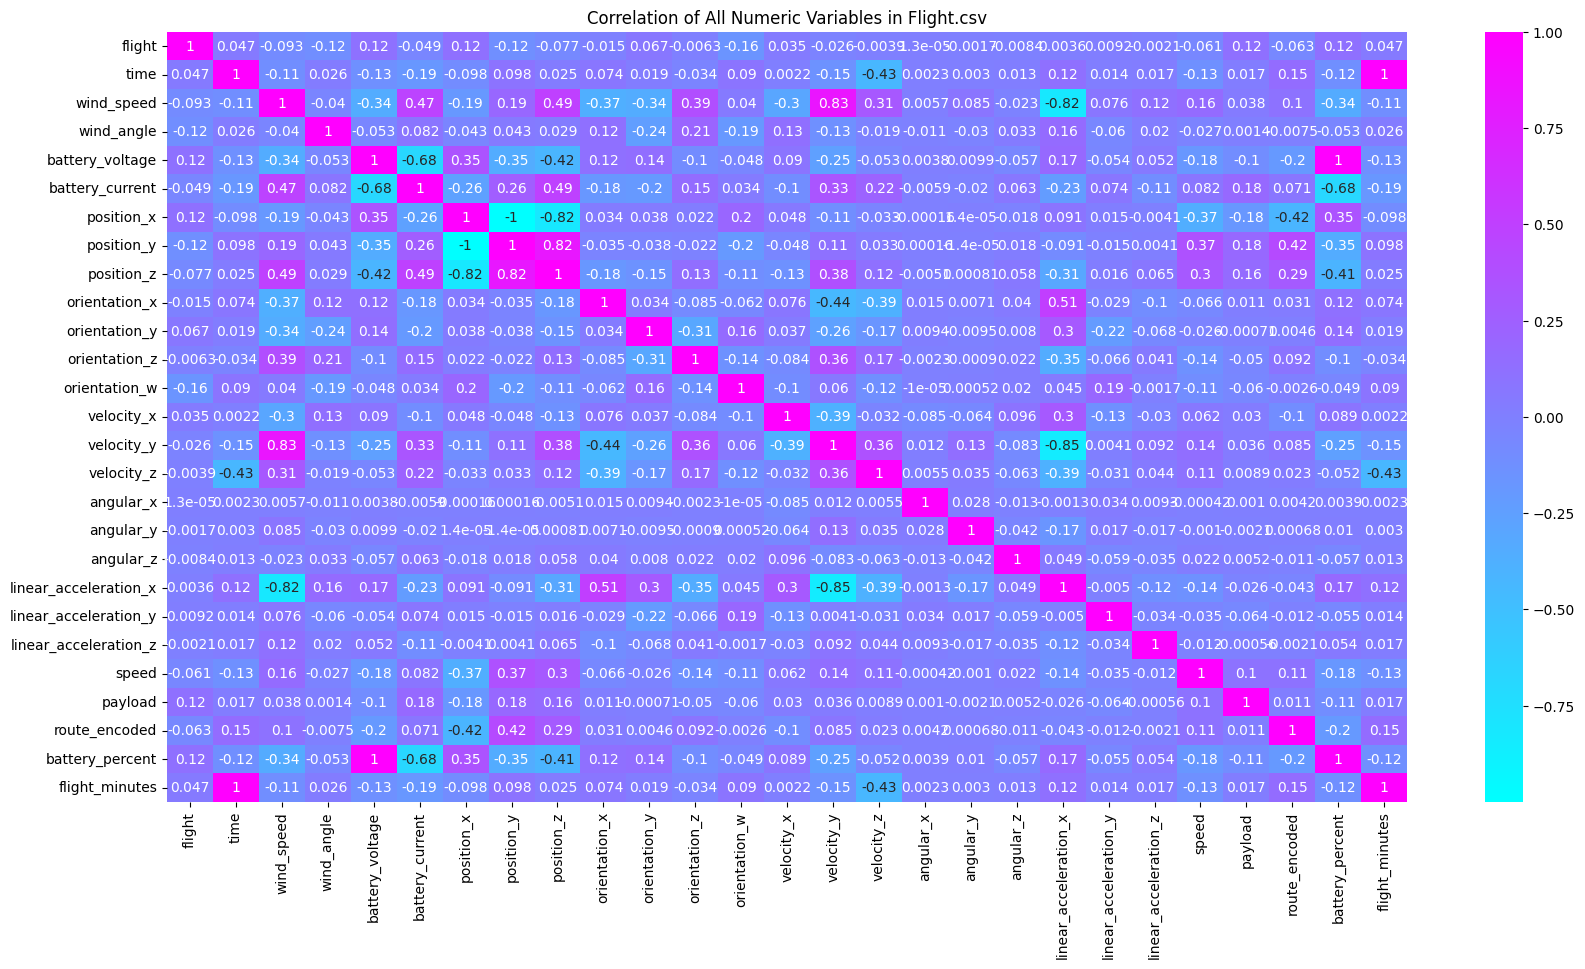

In [23]:
# Correlation of all numeric columns
plt.figure(figsize=(20, 10)) # Width, height
plt.title('Correlation of All Numeric Variables in Flight.csv')
# Select only numeric columns
numeric_df = drone_df_edited.select_dtypes(include=['number'])

# Calculate the correlation matrix
corr_matrix = numeric_df.corr()

# Plot the heatmap
sns.heatmap(corr_matrix, annot=True, cmap='cool')
plt.show()

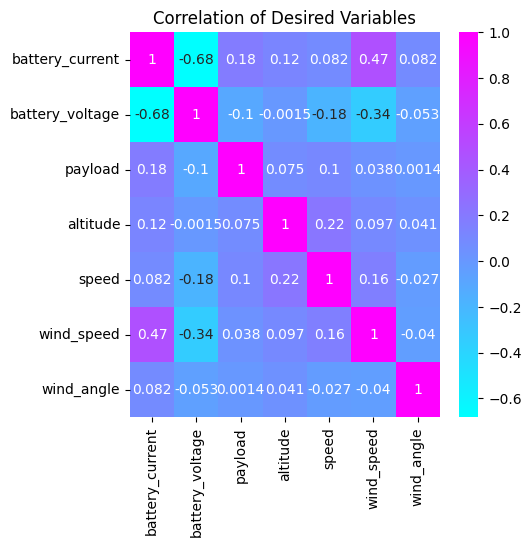

In [24]:
# Define desired columns
prediction1_columns = [
    'battery_current',
    'battery_voltage',
    'payload',
    'altitude',
    'speed',
    'wind_speed',
    'wind_angle'
]
# Correlation of desired columns
plt.figure(figsize=(5, 5)) # Width, height
plt.title('Correlation of Desired Variables')

# Calculate the correlation matrix
corr_matrix = drone_df_edited[prediction1_columns].corr()

# Plot the heatmap
sns.heatmap(corr_matrix, annot=True, cmap='cool')
plt.show()

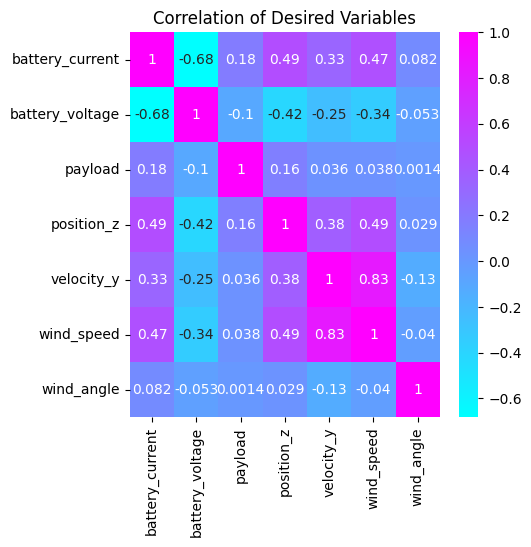

In [26]:
# Define desired columns
prediction2_columns = [
    'battery_current',
    'battery_voltage',
    'payload',
    'position_z',
    'velocity_y',
    'wind_speed',
    'wind_angle'
]
# Correlation of desired columns
plt.figure(figsize=(5, 5)) # Width, height
plt.title('Correlation of Desired Variables')

# Calculate the correlation matrix
corr_matrix = drone_df_edited[prediction2_columns].corr()

# Plot the heatmap
sns.heatmap(corr_matrix, annot=True, cmap='cool')
plt.show()

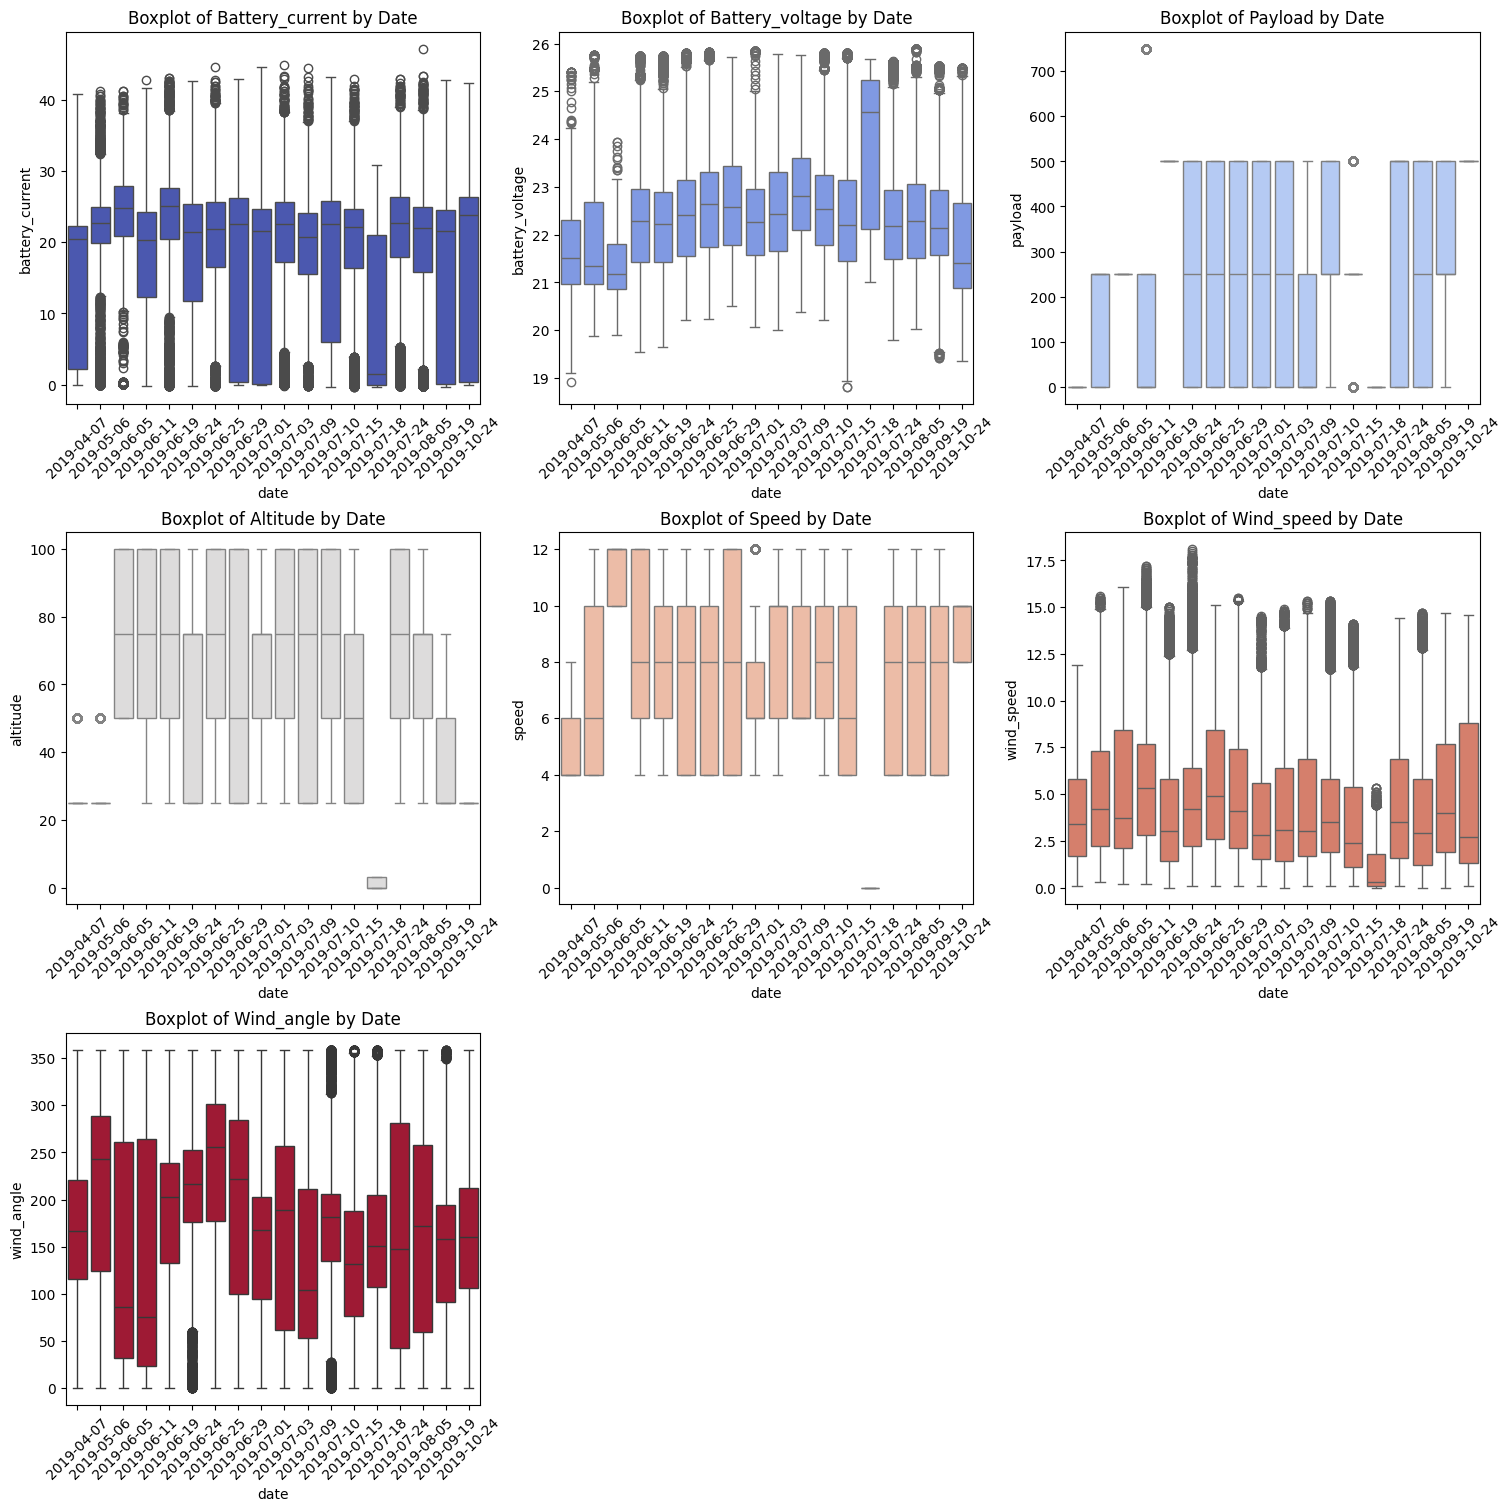

In [29]:
# Generate colors from a matplotlib palette (refined with ChatGPT for space saving)
num_colors = len(prediction1_columns)
colors = cm.coolwarm(np.linspace(0, 1, num_colors))  # Create colors for each subplot

# Define subplot column/rows
num_cols = 3
num_rows = (len(prediction1_columns) + num_cols - 1) // num_cols  # Calculate rows to fit all subplots

# Create the figure and axes
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows), constrained_layout=True)

# Make grid of subplots to iterate
axes = axes.flatten()

# Boxplots with unique color for each subplot
for i, col in enumerate(prediction1_columns):
    sns.boxplot(
        x=drone_df_edited['date'],
        y=drone_df_edited[col],
        color=colors[i],
        ax=axes[i]
    )
    axes[i].set_title(f'Boxplot of {col.capitalize()} by Date')
    axes[i].tick_params(axis='x', rotation=45)  # Rotate x-axis labels for readability

# Hide unused subplots
for j in range(len(prediction1_columns), len(axes)):
    fig.delaxes(axes[j])

plt.show()

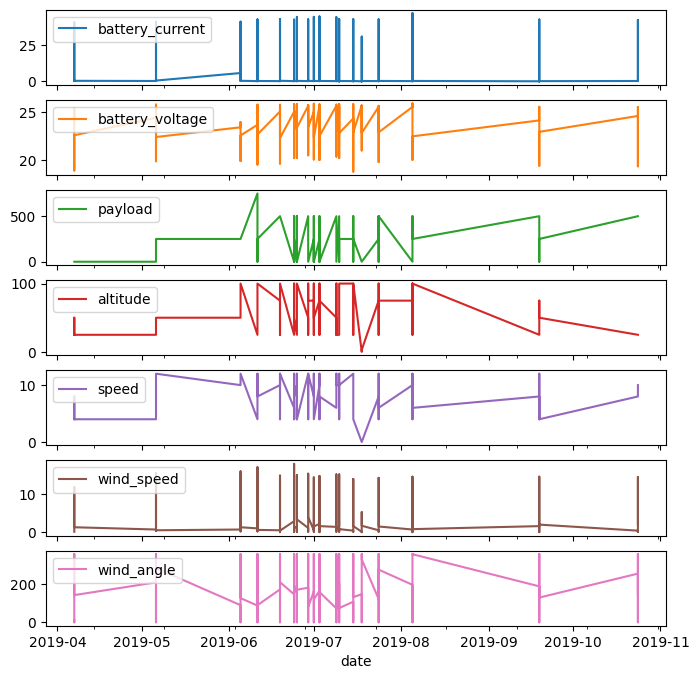

In [30]:
# Initial line plot of desired columns
ax = drone_df_edited.plot('date', prediction1_columns, subplots = True, figsize = (8,8))

# Align legend to upper left
for a in ax.flatten():
    a.legend(loc='upper left')

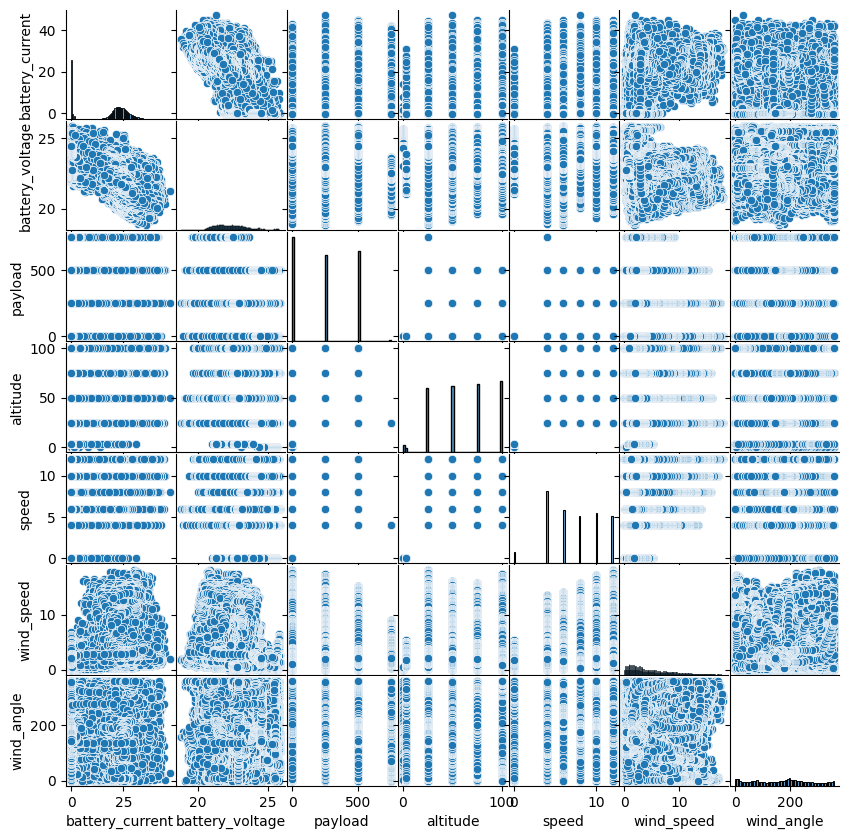

In [31]:
# Pairplot of desired columns
sns.pairplot(drone_df_edited[prediction1_columns], height=8) # Data and individual plot height
plt.gcf().set_size_inches(8, 8)  # Overall figure size
plt.show()

In [32]:
# Calculate daily averages
drone_df_edited[[
    'Battery_current_daily_avg',
    'Battery_voltage_daily_avg',
    'Payload_daily_avg',
    'Altitude_daily_avg',
    'Speed_daily_avg',
    'Wind_speed_daily_avg',
    'Wind_angle_daily_avg'
]] = drone_df_edited.groupby(pd.Grouper(key="datetime", freq="1D"))[prediction1_columns].transform('mean')

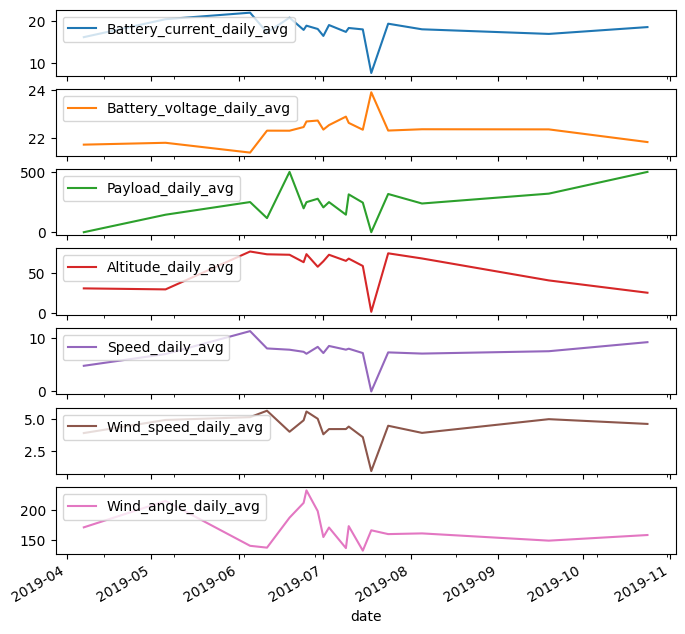

In [33]:
# Sort dataframe by date
drone_df_edited = drone_df_edited.sort_values('date')
# Convert to datetime to enable drop by time period (assisted by Chatgpt)
drone_df_edited['date'] = pd.to_datetime(drone_df_edited['date'])
# Keep 1st row of each date in new dataframe based 1 day period (assisted by Chatgpt)
df_unique_daily = drone_df_edited.loc[drone_df_edited['date'].dt.to_period('D').drop_duplicates().index]

# Build daily avg line plot
ax = df_unique_daily.plot(
    x='date',
    y=[
    'Battery_current_daily_avg',
    'Battery_voltage_daily_avg',
    'Payload_daily_avg',
    'Altitude_daily_avg',
    'Speed_daily_avg',
    'Wind_speed_daily_avg',
    'Wind_angle_daily_avg'
    ],
    subplots=True, figsize = (8,8)
)

# Align legend to upper left
for a in ax.flatten():
    a.legend(loc='upper left')

### <b><u>Prediction 1 (time series): 
<b><u>Predict drone flight energy consumption for future time intervals based on payload, altitude, speed, wind.</b></u>
<br><br><b>predicted/dependent variables:</b> battery_current, battery_voltage
<br><b>feature/independent variables:</b> payload, altitude, speed, wind_speed, wind_angle

### Time Series model using Multiple Linear Regression with month as one of the independent variable

The data used in this study was collected during an experiment designed to empirically measure the energy consumption of small electric Unmanned Aerial Vehicles (UAVs). Data collection took place on randomly selected days over a seven-month period, from April 2019 to October 2019. 

In [34]:
# filter out route not equal to R1 to R7 by using flights with a speed above 0
drone_df_full_flights = drone_df_edited[drone_df_edited['speed'] > 0]

# check the number of unique routes
number_of_unique_routes = drone_df_full_flights['route'].nunique()
print(f'Number of unique routes: {number_of_unique_routes}')

Number of unique routes: 6


To select flights with complete cruise movements (R1-R7), we filtered for speeds above 0, excluding test flights.
Route R7 was eliminated due to non-numerical altitude values during data cleaning, reducing the unique routes to six (R1-R6).

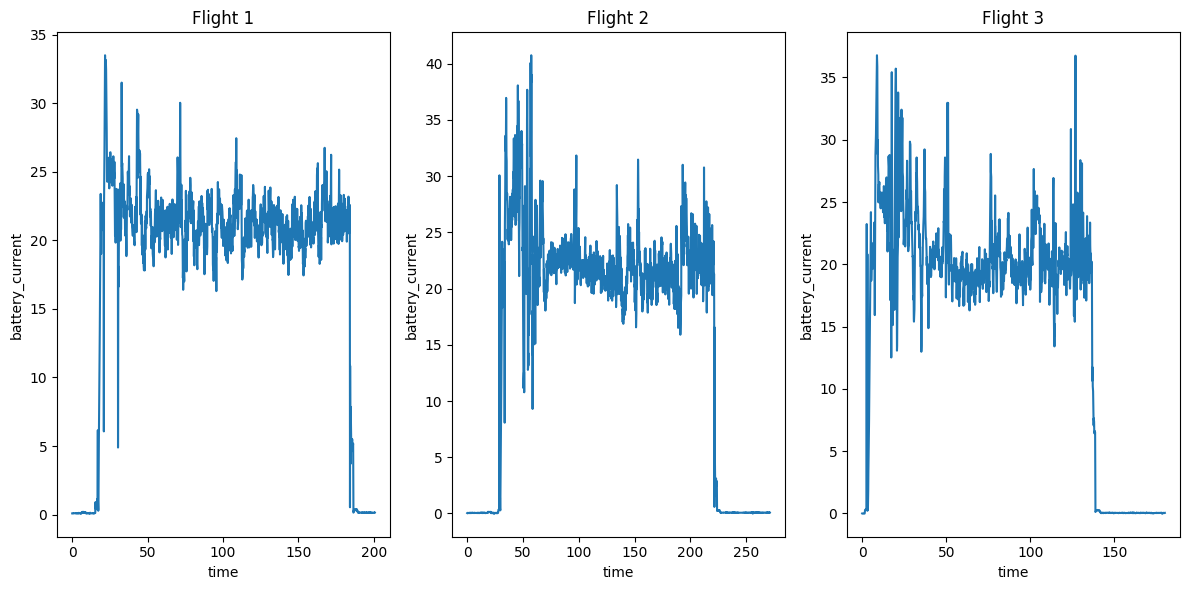

In [35]:
# select flights flight 1 to 5
drone_df_selected_flights = drone_df_full_flights[drone_df_full_flights['flight'].isin([1, 2, 3])]

# plot battery current vs time for each flight
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
sns.lineplot(data=drone_df_selected_flights[drone_df_selected_flights['flight'] == 1], x='time', y='battery_current')
plt.title('Flight 1')

plt.subplot(1, 3, 2)
sns.lineplot(data=drone_df_selected_flights[drone_df_selected_flights['flight'] == 2], x='time', y='battery_current')
plt.title('Flight 2')

plt.subplot(1, 3, 3)
sns.lineplot(data=drone_df_selected_flights[drone_df_selected_flights['flight'] == 3], x='time', y='battery_current')
plt.title('Flight 3')

plt.tight_layout()
plt.show()

Analysis of three flights revealed consistent battery current only during takeoff and landing. Varying flight durations suggest elapsed time may not accurately predict battery current or voltage. Factors like payload, altitude, speed, and wind resistance likely have a greater impact on energy consumption. Instead of elapsed time, we will consider the month, as varying environmental conditions across months can significantly influence energy consumption patterns.

C:\Users\DARiN\AppData\Local\Temp\ipykernel_37956\2033903892.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  drone_df_full_flights['month'] = pd.to_datetime(drone_df_full_flights['date']).dt.month


[ 4  5  6  7  8  9 10]


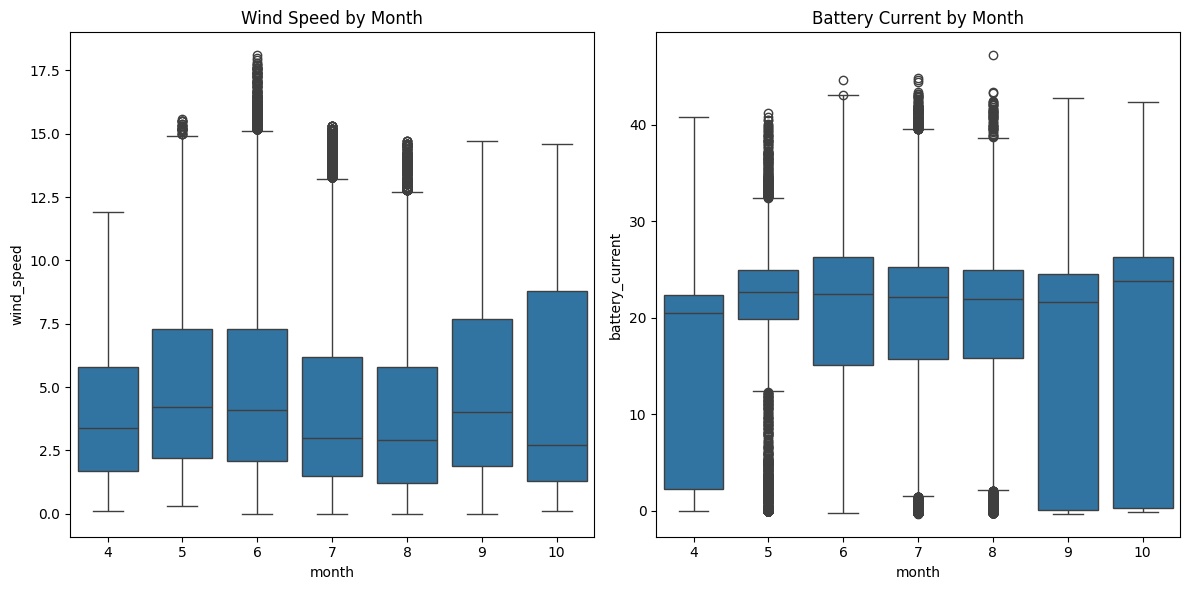

In [36]:
# extract months from variable date 
drone_df_full_flights['month'] = pd.to_datetime(drone_df_full_flights['date']).dt.month

# the unique months
unique_months = drone_df_full_flights['month'].unique()
print(unique_months)

# boxplots of the wind speed by month and battery current by month
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.boxplot(data=drone_df_full_flights, x='month', y='wind_speed')
plt.title('Wind Speed by Month')

plt.subplot(1, 2, 2)
sns.boxplot(data=drone_df_full_flights, x='month', y='battery_current')
plt.title('Battery Current by Month')

plt.tight_layout()
plt.show()

In [37]:
# select the variable of intrest speed, payload, altitude, wind_speed, wind_angle, month, battery_current, battery_voltage
drone_df_selected_variables = drone_df_full_flights[['speed', 'payload', 'altitude', 'wind_speed', 'wind_angle', 'month', 'battery_current', 'battery_voltage']]
drone_df_selected_variables.head()

# summary statistics of the selected variables
drone_df_selected_variables.describe(include='all')

# mapping speed to ordinal variable 4.=1,  6.=2,  8.=3, 10.=4, 12.=5
drone_df_selected_variables['speed'] = drone_df_selected_variables['speed'].map({4: 1, 6: 2, 8: 3, 10: 4, 12: 5})

# mapping payload to ordinal variable 0.=0,  250.=1,  500.=2,  750.=3
drone_df_selected_variables['payload'] = drone_df_selected_variables['payload'].map({0: 0, 250: 1, 500: 2, 750: 3})

# mapping altitude to ordinal variable 0.=0,  25.=1,  50.=2,  75.=3,  100.=4
drone_df_selected_variables['altitude'] = drone_df_selected_variables['altitude'].map({25: 1, 50: 2, 75: 3, 100: 4})

# encode the month variable
drone_df_selected_variables = pd.get_dummies(drone_df_selected_variables, columns=['month'], drop_first=True) 

drone_df_selected_variables.describe(include='all')

C:\Users\DARiN\AppData\Local\Temp\ipykernel_37956\1409051014.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  drone_df_selected_variables['speed'] = drone_df_selected_variables['speed'].map({4: 1, 6: 2, 8: 3, 10: 4, 12: 5})
C:\Users\DARiN\AppData\Local\Temp\ipykernel_37956\1409051014.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  drone_df_selected_variables['payload'] = drone_df_selected_variables['payload'].map({0: 0, 250: 1, 500: 2, 750: 3})
C:\Users\DARiN\AppData\Local\Temp\ipykernel_37956\14090

,speed,payload,altitude,wind_speed,wind_angle,battery_current,battery_voltage,month_5,month_6,month_7,month_8,month_9,month_10
count,245416.000000,245416.000000,245416.000000,245416.000000,245416.000000,245416.000000,245416.000000,245416,245416,245416,245416,245416,245416
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2,2,2,2,2
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False,False
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,234815,165696,138644,217597,236038,242589
mean,2.804291,1.003003,2.539781,4.475198,169.341657,18.370642,22.376483,NaN,NaN,NaN,NaN,NaN,NaN
std,1.451451,0.837693,1.119602,3.484988,101.534014,10.671851,1.142511,NaN,NaN,NaN,NaN,NaN,NaN
min,1.000000,0.000000,1.000000,0.000000,0.000000,-0.302167,18.810810,NaN,NaN,NaN,NaN,NaN,NaN
25%,1.000000,0.000000,2.000000,1.700000,78.000000,15.664994,21.492702,NaN,NaN,NaN,NaN,NaN,NaN
50%,3.000000,1.000000,3.000000,3.400000,179.000000,22.113884,22.287754,NaN,NaN,NaN,NaN,NaN,NaN
75%,4.000000,2.000000,4.000000,6.600000,245.000000,25.421822,23.111605,NaN,NaN,NaN,NaN,NaN,NaN


In [39]:
# mutiple linear regression model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# split the data into train and test
X = drone_df_selected_variables.drop(columns=['battery_current', 'battery_voltage'])
y = drone_df_selected_variables['battery_current']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# fit the model
model = LinearRegression()
model.fit(X_train, y_train)

# predict the battery current
y_pred = model.predict(X_test)

# calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)

print(f'Mean Squared Error: {mse: 0.2f}')

Mean Squared Error:  85.64


In [40]:
import statsmodels.api as sm

# Create X matrix with independent variables (excluding battery_current and battery_voltage)
X = drone_df_selected_variables.drop(['battery_current', 'battery_voltage'], axis=1)

# Convert boolean columns to int
bool_columns = X.select_dtypes(include=['bool']).columns
X[bool_columns] = X[bool_columns].astype(int)

# Add constant term to include intercept in the model
X = sm.add_constant(X)

# Fit the model
model = sm.OLS(y, X).fit()

# Print summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        battery_current   R-squared:                       0.244
Model:                            OLS   Adj. R-squared:                  0.244
Method:                 Least Squares   F-statistic:                     7208.
Date:                Wed, 12 Feb 2025   Prob (F-statistic):               0.00
Time:                        16:59:51   Log-Likelihood:            -8.9493e+05
No. Observations:              245416   AIC:                         1.790e+06
Df Residuals:                  245404   BIC:                         1.790e+06
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.6882      0.113     77.078      0.0

The OLS regression model explains 24.4% of the variance in battery current (R-squared = 0.244), considering predictors such as speed, payload, altitude, wind speed, wind angle, and the month of flight.

Among the time-related variables, the coefficients for the months reveal significant variability in battery current across different months, likely attributed to environmental factors like wind conditions. For instance, flights in May (month_5) are associated with a substantial increase in battery current (+1.4919), while September (month_9) shows the largest decrease (-3.0033).

This analysis underscores the importance of considering temporal factors, specifically seasonal variations, when predicting UAV battery performance.

### <b><u> Prediction 2 (Deep Neural Network Classification):</b></u>
<b><u>Classify optimal flight parameters (altitude, speed, payload) that minimize energy consumption
<br>based upon flight conditions (e.g., wind speed and battery level).</b></u>
<br><br><b>predicted/dependent variables:</b> altitude, speed, payload
<br><b>feature/independent variables:</b> wind_speed, wind_angle, battery_voltage, battery_current 
<br><br><b>other possible independent variables:</b> position (x,y,z), orientation(x,y,z), velocity (x,y,z), angular (x,y,z), linear acceleration (x,y,z))